In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt  
from ipywidgets import widgets

%matplotlib inline

In [2]:
har_ds = pd.read_table('dataset-har-pair-fb.csv',sep=';')

C:\Users\jennhaur\AppData\Local\Continuum\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2902: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
#f = lambda x : x[0]+x[1]
#har_ds['height'] = har_ds['how_tall_in_meters'].str.split(",").apply(f).astype(int)
har_ds['height'] = har_ds['how_tall_in_meters'].str.split(",").apply(lambda x : x[0]+x[1]).astype(int)
del har_ds['how_tall_in_meters']

In [4]:
#f = lambda x : int(x[0])+int(x[1])/10
#har_ds['body_mass_index'].str.split(",").apply(lambda x : int(x[0])+int(x[1])/10)
har_ds['bmi'] = har_ds['body_mass_index'].str.split(",").apply(lambda x : int(x[0])+int(x[1])/10)
del har_ds['body_mass_index']

In [5]:
#pd.unique(har_ds['z4'])
#har_ds['z4'].to_numeric()
#har_ds['z4'].astype(int)

har_ds['z4'] = har_ds['z4'].convert_objects(convert_numeric=True)
har_ds.dtypes


C:\Users\jennhaur\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


user       object
gender     object
age         int64
weight      int64
x1          int64
y1          int64
z1          int64
x2          int64
y2          int64
z2          int64
x3          int64
y3          int64
z3          int64
x4          int64
y4          int64
z4        float64
class      object
height      int32
bmi       float64
dtype: object

In [ ]:


#Option 1
#fig, ax = plt.subplots(5,1,sharex=True)
#har_ds[['class','x1']].groupby('class').boxplot(subplots=True,layout=(1,5),figsize=(15,3),sym="")

#Option 2
#show outliers
#har_ds[['class','x1']].boxplot(by='class',sym="k.")
#ignore outliers
har_ds[['class','x1']].boxplot(by='class',sym="")
har_ds[['class','x2']].boxplot(by='class',sym="")
har_ds[['class','x3']].boxplot(by='class',sym="")
har_ds[['class','x4']].boxplot(by='class',sym="")
har_ds[['class','x1','x2','x3','x4']].boxplot(by='class',sym="")

#Option 3
#df = har_ds[['class','x1']]
#df2 = df.pivot(columns=df.columns[0])
#df2.boxplot()
        

In [ ]:
df = har_ds[['class','x1','x2']]
groups = df[(df['class'] == "sitting") | (df['class'] == "standing")].groupby('class')

groups.plot(x=groups['x1'],y=groups['x2'],kind='scatter',subplots=True,layout=(1,2),figsize=(15,30),legends=True)

#Option 2
#fig, ax = plt.subplots()
# ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
# for name, group in groups:
#     ax.plot(group.x1, group.x2, marker='o', linestyle='', ms=12, label=name)
# ax.legend()
# plt.show()

#har_ds.plot.scatter(x='x1',y='x2')
#har_ds[['class','x1','x2']].groupby('class').plot.scatter(subplots=True,layout=(1,5),figsize=(15,3),sym="")



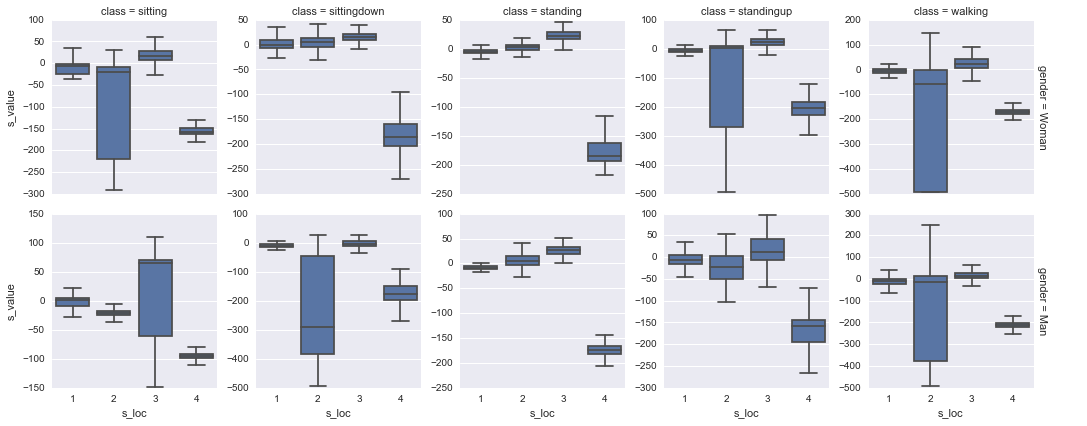

In [29]:
#x1 = waist, x2 = thigh, x3 = ankle, x4 = arm

#g = sb.FacetGrid(har_ds,col='class')
#g.map(plt.scatter,"x1","x2")
#g.map(plt.hist,"x1")

# g1 = sb.FacetGrid(har_ds,col='class',row='gender',margin_titles=True)
# g1.map(plt.scatter,'x1','x2')
# g1.add_legend()

# g2 = sb.FacetGrid(har_ds,col='class',sharey=False,margin_titles=True)
# g2.map(sb.boxplot,'gender','x1')
# g2.add_legend()

#Stacking
#df = har_ds.set_index(['user','gender','class','weight','bmi','height','age'])
#df = df.stack().reset_index()
#df.columns = ['user','gender','class','weight','bmi','height','age','s_axis','s_value']
#df['s_loc'] = df['s_axis'].apply(lambda x: x[1:2])
#df['s_ax'] = df['s_axis'].apply(lambda x: x[:1])

dff = df[(df['s_ax'] == "x")]
g3 = sb.FacetGrid(dff,col='class',row='gender',sharey=False,margin_titles=True)
g3.map(sb.boxplot,'s_loc','s_value',sym="")
g3.add_legend()

In [ ]:
#Data Cleansing NaN
# %timeit har_ds.isnull().any()
#har_ds.isnull().sum()

har_ds.isnull().any()
har_ds.loc[har_ds['z4'].isnull().nonzero()]

har_ds_new = har_ds.drop(har_ds.index[122076])
#har_ds_new.loc[har_ds_new['z4'].isnull().nonzero()]
har_ds_new.isnull().any()

In [31]:
#Pandas Dummies to change Classes to One-Hot Encoding
pd.get_dummies(har_ds['class'])

,sitting,sittingdown,standing,standingup,walking
0,1,0,0,0,0
1,1,0,0,0,0
2,1,0,0,0,0
3,1,0,0,0,0
4,1,0,0,0,0
5,1,0,0,0,0
6,1,0,0,0,0
7,1,0,0,0,0
8,1,0,0,0,0
9,1,0,0,0,0


In [ ]:
# Split to training set and test set , cross validation
# Random Forest
# C4.5 Decision Tree / ID3 / Adaboost ? Adaboost with 10 iteration, C4.5 confidence factor 0.25
# 99.4% using 10-fold cross validation (sitting 100%, sitting down 96.9% , standing 99.8% , standing up 96.9% walking 99.8%)
# Confusion Matrix